# Processing a signal

This notebook walks through the basics of analyzing the instantaneous frequency, and what to do with that result.

For this example, we will use a synthetic signal generated via the ```ffta.simulate``` submodule. From there, we primarily turn to the ```ffta.pixel.Pixel``` code.

In [1]:
import ffta
import numpy as np
from matplotlib import pyplot as plt
from ffta.simulation import mechanical_drive

c:\users\raj\documents\coding\pyusid\pyusid\pyUSID\viz\__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


In [14]:
# We'll create a simple cantilever signal with a single exponential excitation

# An example set of simulation parameters are in the FFTA repo under simulation/examples_params
params_url = 'https://raw.githubusercontent.com/rajgiriUW/ffta/master/ffta/simulation/example_params/example_sim_params.cfg'
params = ffta.simulation.utils.load.simulation_configuration(params_url, is_url=True)

# Simulation will be 5 ms long, with an excitation of time constant 100 us 
params[2]['total_time'] = 0.005
params[1]['tau'] = 1e-4

# Simulate the cantilever
c = mechanical_drive.MechanicalDrive(*params)
Z, _ = c.simulate()
Z /= params[0]['amp_invols'] # for scaling, normally unnecessary but just for this example

### The Pixel Class

Pixel takes a lot of parameters, but at its core it really just needs three things:

1) A signal
2) A trigger for when in time the excitation occurs
3) Either the total_time of the signal or the sampling rate (you can calculate one from the other

Typically, in the Ginger lab, these are all pre-supplied in an associated configuration file (parameters.cfg) that is saved with the data. But, you can also supply all those things explicitly.

Here are all the parameters; you should refer to the [documentation for Pixel](https://ffta.readthedocs.io/en/latest/source/ffta.html#pixel)
 ```
 signal_array, # the actual signal
 params={}, # the parameters file, can be overridden by parameters below
 can_params={}, # optional set of cantilever parameters like AMPINVOLS, etc
 fit=True, # whether to use a fitting function to analyze the data
 pycroscopy=False, # only used in other functions
 method='hilbert', # Any of hilbert, stft, wavelet, or nfmd
 fit_form='product', # Usually don't change
 filter_amplitude=False, # Filters the instantaneous amplitude (usually needed)
 filter_frequency=False, # Filters the frequency around its DC value (experimental feature)
 recombination=False, # For data where the charging is an INCREASE in frequency (like charge recombination)
 trigger=None, # When in time the event occurs
 total_time=None, # How long the signal is
 sampling_rate=None, # the sampling rate, e.g. 10000000 (10 MHZ)
 roi=None # The range after the signal within which to find the frequency shift minimum (roi = region of interest)
 ```

Text(0.5, 1.0, 'Cantilever deflection')

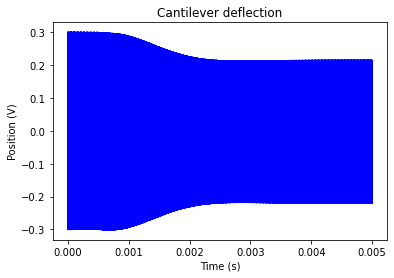

In [21]:
# Create a pixel object; the first three are minimally required. 
pix = ffta.pixel.Pixel(Z, trigger=5e-4, total_time=5e-3, roi=1e-3)

plt.plot(np.arange(0, pix.total_time, 1/pix.sampling_rate), Z, 'b')
plt.xlabel('Time (s)')
plt.ylabel('Position (V)')
plt.title('Cantilever deflection')

### Analyzing the signal

Now that we have Pixel, the basic analysis is achieved simply through:

```pix.analyze()```

and visualized via

```pix.plot()```

The plot is a shortcut that plots the key attributes: **instantanous frequency** (overlaid with a fit), the **instantaneous amplitude**, and the **instantaneous phase**.
We can change a lot of parameters and readjust things. You can edit the class attributes directly. For example, we'll first show the default, and then we will *decrease the number of filter taps used*

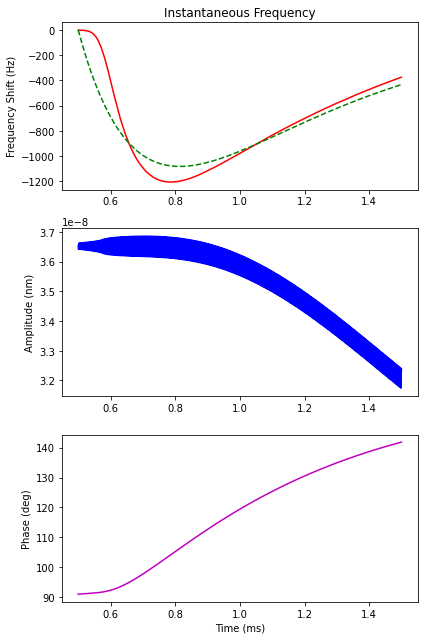

In [22]:
# Default conditions
pix.analyze()
pix.plot()

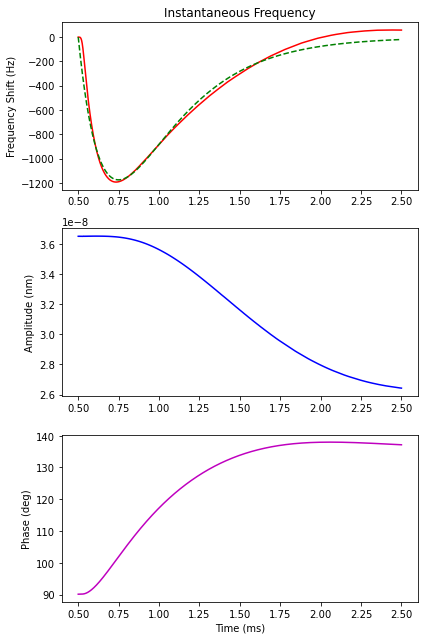

In [23]:
pix.n_taps = 499
pix.filter_amplitude = True
pix.roi = 2e-3
pix.analyze()
pix.plot()

## What happened?

We decreased the filter ```n_taps``` (number of coefficients in the Finite Impulse Response filter) from the default case of 1499 to 499, so the step is sharper. Second, we added the ```filter_amplitude=True``` flag to, well, filter the ammplitude so it actually looks like an envelope of the raw deflection. Lastly, we increased the ```roi``` to show more of the signal.

Next we will explore changing some of the methods used to analyze.

### First, we'll use **STFT** 

Note that STFT is essentially a wrapper of the Scipy spectrogram function.

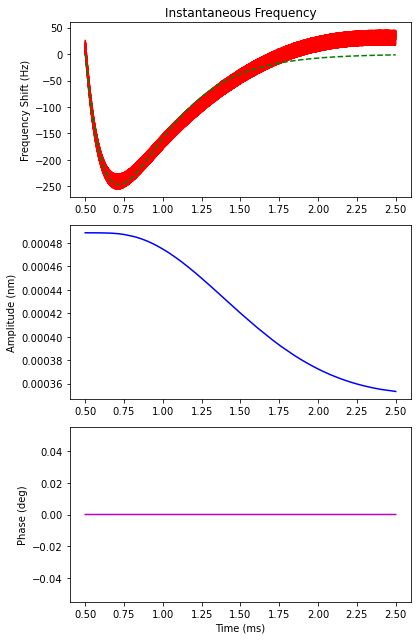

In [29]:
pix.method = 'stft'
pix.analyze()
pix.plot()

### STFTs can produce spectrograms

So, let's plot it! Note that given the nature of STFTs, we need to increase the aspect ratio a ton.

Text(0.5, 1.0, 'STFT Spectrogram')

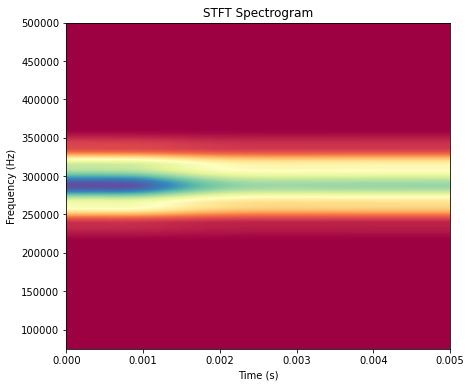

In [70]:
fig, ax = plt.subplots(figsize=(8,6), facecolor='white')
ax.imshow(pix.spectrogram[3:20,:], cmap='Spectral', origin='lower', aspect=1e-8, 
           extent=[0, 5e-3, pix.stft_freq[3], pix.stft_freq[20]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('STFT Spectrogram')

### Spectrograms are neat but computationally expensive

The reason to use the default Hilbert transform is primarily that it's very very fast.

But the STFT clearly tells use that we have lots of concentrated frequency signal that is then spread out post-excitation. 

The primary factor you can change is ```fft_time_res```, so let's increase that.

Error with nfft setting


Text(0.5, 1.0, 'STFT Spectrogram')

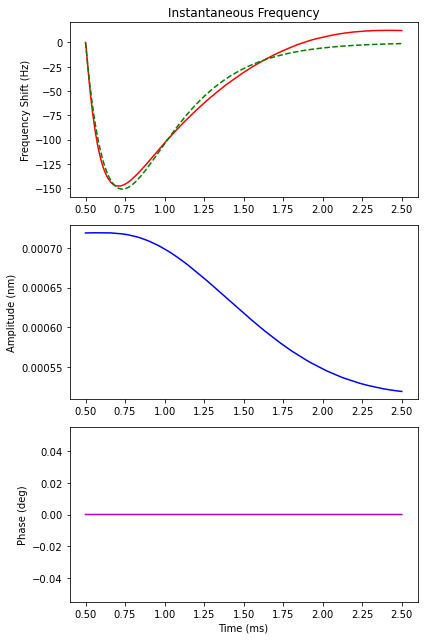

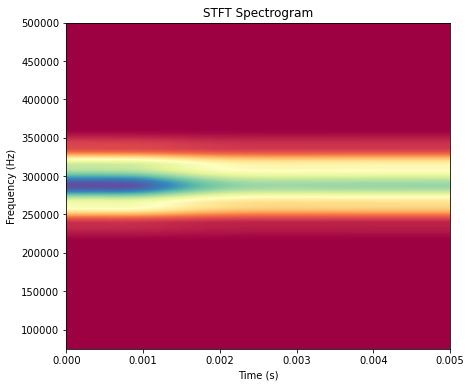

In [71]:
pix.method = 'stft'
pix.fft_time_res = 40e-6
pix.analyze()
pix.plot()

fig, ax = plt.subplots(figsize=(8,6), facecolor='white')
ax.imshow(pix.spectrogram[3:20,:], cmap='Spectral', origin='lower', aspect=1e-8, 
           extent=[0, 5e-3, pix.stft_freq[3], pix.stft_freq[20]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('STFT Spectrogram')

That looks about the same, but the extracted frequency is much smoother.

### Lastly, we'll use Continuous Wavelet Transform

Text(0.5, 1.0, 'CWT Spectrogram')

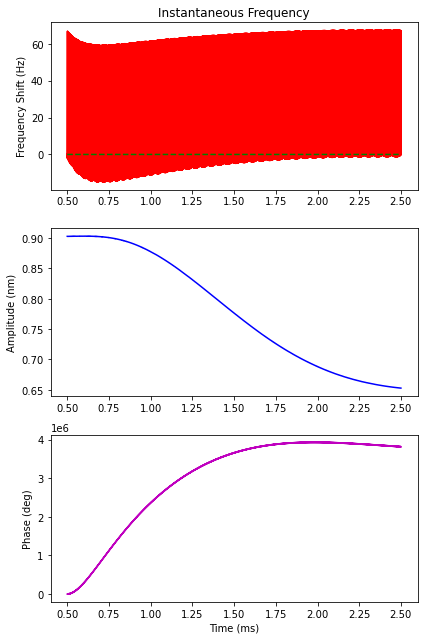

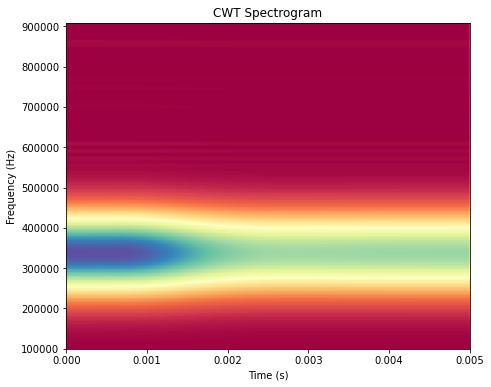

In [101]:
pix.method = 'wavelet'
pix.analyze()
pix.plot()
fig, ax = plt.subplots(figsize=(8,6), facecolor='white')
ax.imshow(pix.spectrogram[:,:], cmap='Spectral', origin='upper', aspect=5e-9,
          extent=[0, 5e-3, pix.wavelet_freq[0], pix.wavelet_freq[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('CWT Spectrogram')

### This is very noisy!

Explaining this requires some digression into how wavelets work. Essentially, unlike an STFT, the wavelet has a more dynamic scaling in the time and frequency axes. The factor that controls "smoothing" here is ```pix.scales``` which is a numpy array defining what *wavelet scales* to process the signal over.

A small scale value corresponds to a more compressed wavelet, which is good for higher-frequency information at the expense of being broader in time. Larger scales work the opposite, allowing better time resolution but worse frequency resolution. In the STFT, these values are essentially fixed. 

So, the way to improve the smoothing is by something like:

Changing from the default scales:
```
pix.scales = np.arange(100, 10, -1)
```
to coarser steps
```
pix.scales = np.arange(100, 10, -5)
```

Let's try that

Text(0.5, 1.0, 'CWT Spectrogram')

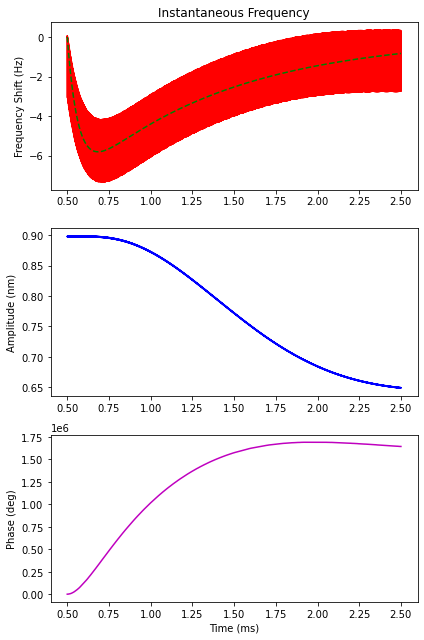

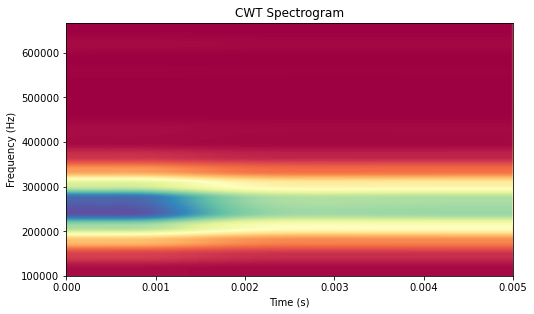

In [102]:
pix.method = 'wavelet'
pix.scales = np.arange(100, 10, -5)
pix.analyze()
pix.plot()
fig, ax = plt.subplots(figsize=(8,6), facecolor='white')
ax.imshow(pix.spectrogram[:,:], cmap='Spectral', origin='upper', aspect=5e-9,
          extent=[0, 5e-3, pix.wavelet_freq[0], pix.wavelet_freq[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('CWT Spectrogram')

## Finally, our last method will be NFMD

Nonstationary Fourier Mode Decomposition, by [Daniel Shea](https://github.com/sheadan/NFMD-ExtractionInstantaneous/) from our recent [paper](https://ieeexplore.ieee.org/document/9448199), is a method that uses mode decomposition (cf. Hilbert-Huang transform) and stochastic gradient descent via PyTorch to iteratively fit and extract the Fourier modes. Here, we show that we can use this to get much cleaner data.

Note that **this can be much slower than the other methods**, probably ~30 seconds to finish

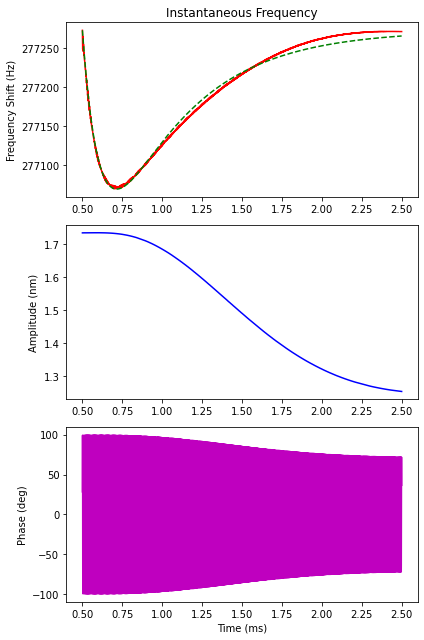

In [103]:
pix.method='nfmd'
pix.analyze()
pix.plot()

## NFMD also yields different modes, so we can plot all of those together.

For example, in the paper cited above, we noted that the "time-dependent mean" might be a useful parameter to track the hidden time constant defining the excitation.

The following is from Daniel Shea's GitHub, see above.